<a href="https://colab.research.google.com/github/farheenfathimaa/NLP-with-Disaster-Tweets/blob/main/Natural_Language_Processing_with_Disaster_Tweets_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# mounting drive
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [20]:
# Unzip the uploaded data into Google Drive
#!unzip "/content/drive/MyDrive/nlp-getting-started.zip" -d "/content/drive/MyDrive/nlp-tweets"

# Natural Language Processing with Disaster Tweets

This notebook looks into various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

We're going to take the following approach:

1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

It is available on Kaggle. [Link](https://www.kaggle.com/competitions/nlp-getting-started/overview)



In [21]:
#!pip install tensorflow

The code below is the copy of [Link](https://www.kaggle.com/code/nabeelparuk/nlp-disaster-tweet-sentiment-analysis)

This is attempt of understanding the real time working on a NLP problem

## Importing modules

In [22]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization, Embedding
import tensorflow_hub as hub
#import tensorflow_text as text

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import random
import datetime
import matplotlib.pyplot as plt
import io
from IPython.display import FileLink

import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis
### Import data

In [23]:
train_df = pd.read_csv("/content/drive/MyDrive/nlp-tweets/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/nlp-tweets/test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [24]:
train_df_shuffled = train_df.sample(frac=1, random_state=1)
train_df_shuffled.head()

,id,keyword,location,text,target
3228,4632,emergency%20services,"Sydney, New South Wales",Goulburn man Henry Van Bilsen missing: Emergen...,1
3706,5271,fear,NaN,The things we fear most in organizations--fluc...,0
6957,9982,tsunami,Land Of The Kings,@tsunami_esh ?? hey Esh,0
2887,4149,drown,NaN,@POTUS you until you drown by water entering t...,0
7464,10680,wounds,"cody, austin follows ?*?",Crawling in my skin\nThese wounds they will no...,1


In [25]:
train_df.isna().sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


In [26]:
train_df["target"].value_counts()

,count
target,
0,4342
1,3271


In [27]:
# Visualising few samples
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target>0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
@MNPDNashville @MontalbanoNY sadly suicide by cop. Wed 2PM @ Dollar movie does not a mass murder make.

---

Target: 1 (real disaster)
Text:
./.....hmm 12000 Nigerian refugees repatriated from Cameroon http://t.co/96p3hUJNTj /(

---

Target: 1 (real disaster)
Text:
The gusto in persist had amongst empty-pated communication explosion: hPSsJD

---

Target: 0 (not real disaster)
Text:
@ToxicSavior_ -a loud bang. He froze on the spot as slowly every head turned towards him. One of the things he hated the most was to be -

---

Target: 0 (not real disaster)
Text:
def louis is tired plus the meltdown of fans when he confirmed he's a dad but some fans are reaching 
making conclusions and stuff

---



## Preprocessing
### Split into training and validation data

In [28]:
# Set target and predictors
X = train_df_shuffled["text"].to_numpy()
y = train_df_shuffled["target"].to_numpy()

# Split
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  random_state=42,
                                                  test_size=0.2)

###Text vectorization

In [29]:
# Find average number of tokens in tweets
round(sum([len(i.split()) for i in X_train])/len(X_train))

15

In [30]:
# Set custom parameters
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_sequence_length=max_length)
text_vectorizer.adapt(X_train)

In [31]:
# Test on random sentence
random_sentence = random.choice(X_train)
print(f"Text:\n{random_sentence}\n\nAfter vectorization:\n{text_vectorizer([random_sentence])}")

Text:
Still and Box alarm for the train derailment at 61st and Calumet struck out on the orders of 2-1-21. #ChicagoScanner

After vectorization:
[[  86    8 1440  973   10    2  117  411   17 5806    8 5554 1621   39
    11]]


Let's look at some common words

In [32]:
# Get common values
vocab_words = text_vectorizer.get_vocabulary()

# Get the least and the most common words
most_common = vocab_words[:5]
least_common = vocab_words[-5:]
print(f"Most common: {most_common}\nLeast_common: {least_common}")

Most common: ['', '[UNK]', 'the', 'a', 'in']
Least_common: ['mildmannered', 'milc5040h', 'mil', 'mikecroninwmur', 'mihirssharma']


## Embedding
We use embedding to make the vectorized text learnable

In [33]:
# Create embedding layer
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             input_length=max_length,
                             name="embedding_1")

In [34]:
# Choose random sentence
random_sentence = random.choice(X_train)
print("Original sentence:", random_sentence)

# Embed sentence -> can't use straight text
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original sentence: How many baskets did  A Charming Fatality by @tonyakappes11 get? http://t.co/xyav4T5n0O #Mystery #Paranormal


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.03895224, -0.0079249 ,  0.01246826, ..., -0.02503668,
         -0.0067646 ,  0.04997103],
        [-0.00279677, -0.04421072, -0.02010795, ..., -0.03791052,
          0.01679805,  0.02974239],
        [-0.01817123,  0.0213845 , -0.02291819, ...,  0.03470229,
          0.01635427,  0.00107307],
        ...,
        [-0.04416661,  0.00659661, -0.00339939, ..., -0.04722473,
          0.03584695, -0.03409718],
        [-0.04087963, -0.01220429, -0.04745679, ...,  0.0292411 ,
          0.0164717 ,  0.02132947],
        [-0.04087963, -0.01220429, -0.04745679, ...,  0.0292411 ,
          0.0164717 ,  0.02132947]]], dtype=float32)>

## Model Construction
Define useful functions

*Metrics dictionary*

In [35]:
def metrics_dict(y_true, y_preds):
  """Gives the accuracy, precision, recall and f1 score"""
  acc = accuracy_score(y_true, y_preds)
  prec = precision_score(y_true, y_preds)
  recall = recall_score(y_true, y_preds)
  f1 = f1_score(y_true, y_preds, average="weighted")

  metrics = {"Accuracy":acc,
             "Precision":prec,
             "Recall":recall,
             "F1 Score":f1}
  return metrics

*TensorBoard Callback*

In [42]:
def create_tensorboard_callback(dir_name, exp_name):
  """
  Create a TensorBoard callback to store log files

  Store log files with filepath:
  "dir_name/exp_name/current_datetime"

  Args:
    dir_name: Target directory
    exp_name: Name of the experiment directory
  """
  log_dir = dir_name + "/" + exp_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

SAVE_DIR = "/content/drive/MyDrive/nlp-tweets/model_logs"

## Model 0 | Naive Bayes | Baseline Model
### Build model

In [38]:
# Create vectorizer
bayes_vectorizer = TfidfVectorizer()

# Build pipeline
model_0 = Pipeline([
    ("tfidf", bayes_vectorizer),
    ("clf", MultinomialNB())
])

# Fit the model
model_0.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

###Evaluate model

In [39]:
# Get predictions
model_0_preds = model_0.predict(X_val)

# Compute metrics
model_0_metrics = metrics_dict(y_val, model_0_preds)
model_0_metrics

{'Accuracy': 0.8089297439264609,
 'Precision': 0.8636363636363636,
 'Recall': 0.6363636363636364,
 'F1 Score': 0.8025095513670459}

## Model 1 | Feed-forward Neural Network
### Build Model

In [43]:
# Build model (using fuctional API)
inputs = layers.Input(shape=(1, ), dtype=tf.string)

# Turn text into numbers
x = text_vectorizer(inputs)
x = embedding(x)

# Hidden layers
x = layers.GlobalAveragePooling1D()(x)

# Output layers
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs,
                         outputs,
                         name="model_1_feedforward")

# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
history_1 = model_1.fit(x=X_train,
                        y=y_train,
                        validation_data=(X_val, y_val),
                        epochs=5,
                        callbacks=[create_tensorboard_callback(SAVE_DIR,model_1.name)])

Saving TensorBoard log files to: /content/drive/MyDrive/nlp-tweets/model_logs/model_1_feedforward/20240826-060758
Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6422 - loss: 0.6564 - val_accuracy: 0.7695 - val_loss: 0.5268
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8094 - loss: 0.4743 - val_accuracy: 0.7984 - val_loss: 0.4595
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8559 - loss: 0.3690 - val_accuracy: 0.7984 - val_loss: 0.4481
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8917 - loss: 0.2931 - val_accuracy: 0.7997 - val_loss: 0.4571
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9094 - loss: 0.2477 - val_accuracy: 0.7991 - val_loss: 0.4729


In [44]:
model_1.summary()

Model: "model_1_feedforward"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,840,389 (14.65 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,260 (9.77 MB)

### Evaluate model

In [47]:
# Get predictions
model_1_pred_probs = model_1.predict(X_val)
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

# Compute metrics
model_1_metrics = metrics_dict(y_val, model_1_preds)
model_1_metrics

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


{'Accuracy': 0.799080761654629,
 'Precision': 0.7743589743589744,
 'Recall': 0.722488038277512,
 'F1 Score': 0.797900089688689}

<Figure size 640x480 with 0 Axes>

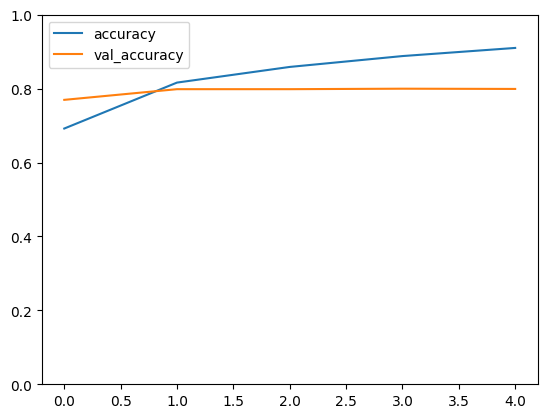

In [52]:
# Plot accuracy curves
history1_plot = pd.DataFrame(history_1.history)

plt.figure()
history1_plot.loc[ : ,["accuracy", "val_accuracy"]].plot()
plt.ylim(0,1);

## Visualise learned embedding
*Navigate to [TensorFlow Embedding Projector](https://projector.tensorflow.org/)*

In [54]:
# Get vocobulary
words_in_vocab = text_vectorizer.get_vocabulary()

# Get weight metrix of embeddign layer
embed_weights_model_1 = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights_model_1.shape)

(10000, 128)


### Download the files

In [56]:
# Create ouput writers
out_v = io.open("embedding_vectors_model1.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata_model1.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to files
for num, word in enumerate(words_in_vocab):
  if num==0:
    continue # skip padding token
  vec = embed_weights_model_1[num]
  out_m.write(word +"\n") # word to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

### Generate download links

In [57]:
FileLink("embedding_vectors.tsv")

/content/embedding_vectors.tsv

In [58]:
FileLink("embedding_metadata.tsv")

/content/embedding_metadata.tsv

##Model 2 | LSTM
###Build Model

In [ ]:
# input
inputs = layers.Input(shape=(1,), dtype=tf.string)

# Turn string